
MixMatch. FixMatch.


#Мета
Ознайомлення з state-of-the-art алгоритмами напівкерованого навчання MixMatch та FixMatch.




#Хід роботи

## 1. Виконання налаштування робочого середовища

In [1]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 29.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.8/252.8 kB 33.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.9 MB/s eta 0:00:00


In [2]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import time
import wandb
from itertools import cycle

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Subset, Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [4]:
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

In [37]:
# set hyperparameters
batch_size = 32
K = 2
lr = 5e-5
epochs = 40
log_freq = 10
ema_decay = 0.999
lambda_u = 25
T = 0.5

## 2. Завантаження набору даних MNIST

In [48]:
class UnlabelDataset(Dataset):
    def __init__(self, dataset, indices, transform, K=2):
        self.dataset = Subset(dataset, indices)
        self.transform = transform
        self.K = K

    def __len__(self):
        return len(self.dataset)


    def __getitem__(self, index):
        img, label = self.dataset[index]
        imgs = []

        for i in range(self.K):
            imgs.append(self.transform(img))

        return imgs


def get_mnist(root, transform, transform_unlabeled, K, labeled_percent=0.3, val_percent=0.2, random_seed=42):

    mnist_dataset = torchvision.datasets.MNIST(root, train=True, download=True, transform=transform)
    num_classes = len(set(mnist_dataset.targets.numpy()))

    labeled_size = int(len(mnist_dataset) * labeled_percent)
    val_size = int(len(mnist_dataset) * val_percent)
    unlabeled_size = len(mnist_dataset) - labeled_size - val_size

    labeled_idxs, unlabeled_idxs, val_idxs = train_val_split(mnist_dataset.targets, labeled_percent, val_percent, random_seed)
    train_labeled_dataset = Subset(mnist_dataset, labeled_idxs)
    train_unlabeled_dataset = UnlabelDataset(mnist_dataset, unlabeled_idxs, transform=transform_unlabeled, K=K)
    val_dataset = Subset(mnist_dataset, val_idxs)

    test_dataset = torchvision.datasets.MNIST(root, train=False, download=True, transform=transform)

    print(f"#Labeled: {len(train_labeled_dataset)} #Unlabeled: {len(train_unlabeled_dataset)} #Val: {len(val_dataset)}")

    return train_labeled_dataset, train_unlabeled_dataset, val_dataset, test_dataset

def train_val_split(labels, labeled_percent=0.1, val_percent=0.1, random_seed=42):
    np.random.seed(random_seed)
    indices = np.arange(len(labels))

    train_val_size = int((1 - val_percent) * len(labels))
    labeled_size = int(labeled_percent * train_val_size)

    np.random.shuffle(indices)

    train_labeled_idxs = indices[:labeled_size]
    train_unlabeled_val_idxs = indices[labeled_size:train_val_size]
    val_idxs = indices[train_val_size:]

    return train_labeled_idxs, train_unlabeled_val_idxs, val_idxs

In [49]:
# Data

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])


transform_unlabeled = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomAffine(degrees=(-30, 30), scale=(0.5, 1.2)),
    transforms.RandomRotation(degrees=(0, 30)),
    transforms.RandomPerspective(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

train_labeled_set, train_unlabeled_set, val_set, test_set = get_mnist('./data', transform=transform, transform_unlabeled=transform_unlabeled, K=K)
labeled_trainloader = DataLoader(train_labeled_set, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)
unlabeled_trainloader = DataLoader(train_unlabeled_set, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0)

#Labeled: 14400 #Unlabeled: 33600 #Val: 12000


## 5. Завантажимо та налаштуємо нейронну мережу

In [50]:
class ClassifierCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(ClassifierCNN, self).__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=32*12*12,
                      out_features=num_classes)
        )

    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        # print(x.shape)
        x = self.classifier(x)
        return torch.softmax(x, dim=1)

def create_model(ema=False):
    model =  ClassifierCNN(num_classes=10).to(device)
    if ema:
        for param in model.parameters():
            param.detach_()

    return model

In [51]:
def linear_rampup(current, rampup_length=epochs):
    if rampup_length == 0:
        return 1.0
    else:
        current = np.clip(current / rampup_length, 0.0, 1.0)
        return float(current)


class SemiLoss(object):
    def __call__(self, outputs_x, targets_x, outputs_u, targets_u):
        probs_u = torch.softmax(outputs_u, dim=1)

        Lx = -torch.mean(torch.sum(F.log_softmax(outputs_x, dim=1) * targets_x, dim=1))
        Lu = torch.mean((probs_u - targets_u)**2)

        return Lx, Lu


class WeightEMA(object):
    def __init__(self, model, ema_model, alpha=0.999):
        self.model = model
        self.ema_model = ema_model
        self.alpha = alpha
        self.params = list(model.state_dict().values())
        self.ema_params = list(ema_model.state_dict().values())
        self.wd = 0.02 * lr

        for param, ema_param in zip(self.params, self.ema_params):
            param.data.copy_(ema_param.data)

    def step(self):
        one_minus_alpha = 1.0 - self.alpha
        for param, ema_param in zip(self.params, self.ema_params):
            if ema_param.dtype==torch.float32:
                ema_param.mul_(self.alpha)
                ema_param.add_(param * one_minus_alpha)
                # customized weight decay
                param.mul_(1 - self.wd)


def interleave_offsets(batch, nu):
    groups = [batch // (nu + 1)] * (nu + 1)

    for x in range(batch - sum(groups)):
        groups[-x - 1] += 1

    offsets = [0]

    for g in groups:
        offsets.append(offsets[-1] + g)

    assert offsets[-1] == batch
    return offsets


def interleave(xy, batch):
    nu = len(xy) - 1
    offsets = interleave_offsets(batch, nu)
    xy = [[v[offsets[p]:offsets[p + 1]] for p in range(nu + 1)] for v in xy]

    for i in range(1, nu + 1):
        xy[0][i], xy[i][i] = xy[i][i], xy[0][i]

    return [torch.cat(v, dim=0) for v in xy]

In [52]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


In [53]:
def label_guessing(model, inputs_u, inputs_u2):
  outputs_u = model(inputs_u)
  outputs_u2 = model(inputs_u2)
  p = (torch.softmax(outputs_u, dim=1) + torch.softmax(outputs_u2, dim=1)) / 2
  pt = p**(1/T)

  # Apply temperature sharpening to the average predicti
  targets_u = pt / pt.sum(dim=1, keepdim=True)
  targets_u = targets_u.detach()

  return targets_u


def mixup(all_inputs, all_targets, alpha):
  l = np.random.beta(alpha, alpha)
  l = max(l, 1-l)

  idx = torch.randperm(all_inputs.size(0))

  x1, x2 = all_inputs, all_inputs[idx]
  y1, y2 = all_targets, all_targets[idx]

  mixed_input = l * x1 + (1 - l) * x2
  mixed_target = l * y1 + (1 - l) * y2

  return mixed_input, mixed_target

In [54]:
def train(labeled_trainloader, unlabeled_trainloader, model, epoch, T=0.5, alpha=0.75):
    accs = AverageMeter()
    losses = AverageMeter()
    losses_x = AverageMeter()
    losses_u = AverageMeter()

    labeled_train_iter = cycle(iter(labeled_trainloader))

    model.train()
    for batch_idx, (inputs_u, inputs_u2) in tqdm(enumerate(unlabeled_trainloader)):
        inputs_x, targets_x = next(labeled_train_iter)

        batch_size = inputs_x.size(0)

        # Transform label to one-hot
        targets_x_oh = torch.zeros(batch_size, 10).scatter_(1, targets_x.view(-1,1).long(), 1)

        inputs_x, targets_x_oh = inputs_x.cuda(), targets_x_oh.cuda(non_blocking=True)
        targets_x = targets_x.cuda()
        inputs_u, inputs_u2 = inputs_u.cuda(), inputs_u2.cuda()

        with torch.no_grad():
            # compute guessed labels of unlabel samples
            targets_u = label_guessing(model, inputs_u, inputs_u2)

        # mixup
        all_inputs = torch.cat([inputs_x, inputs_u, inputs_u2], dim=0)
        all_targets = torch.cat([targets_x_oh, targets_u, targets_u], dim=0)
        mixed_input, mixed_target = mixup(all_inputs, all_targets, alpha)

        # interleave labeled and unlabed samples between batches to get correct batchnorm calculation
        mixed_input = interleave(list(torch.split(mixed_input, batch_size)), batch_size)

        logits = [model(mixed_input[0])]
        for input in mixed_input[1:]:
            logits.append(model(input))

        # put interleaved samples back
        logits = interleave(logits, batch_size)
        logits_x = logits[0]
        logits_u = torch.cat(logits[1:], dim=0)

        Lx, Lu = train_criterion(logits_x, mixed_target[:batch_size], logits_u, mixed_target[batch_size:])
        w = lambda_u * linear_rampup(epoch+batch_idx/len(labeled_trainloader))
        loss = Lx + w * Lu

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        ema_optimizer.step()

        # compute accuracies
        probs = torch.softmax(model(inputs_x), dim=1)
        predicted_labels = torch.argmax(probs, dim=1)
        correct = predicted_labels == targets_x
        accuracy = correct.sum() / float(targets_x.size(0))

         # record loss
        losses.update(loss.item(), inputs_x.size(0))
        losses_x.update(Lx.item(), inputs_x.size(0))
        losses_u.update(Lu.item(), inputs_x.size(0))
        accs.update(accuracy, inputs_x.size(0))

    return (losses.avg, losses_x.avg, losses_u.avg, accs.avg)

In [55]:
def valid(val_loader, model, epoch):
  losses = AverageMeter()
  accuracies = AverageMeter()

  model.eval()
  with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(val_loader):
      inputs, targets = inputs.cuda(), targets.cuda(non_blocking=True)
      outputs = model(inputs)
      loss = criterion(outputs, targets)

      ## compute metrics
      # accuracy
      probs = torch.softmax(outputs, dim=1)
      predicted_labels = torch.argmax(probs, dim=1)

      correct = predicted_labels == targets
      accuracy = correct.sum() / float(targets.size(0))

      # update the loss and metrics
      losses.update(loss.item(), inputs.size(0))
      accuracies.update(accuracy, inputs.size(0))

  return losses.avg, accuracies.avg

In [56]:
def train_model(model, labeled_trainloader, unlabeled_trainloader, epochs, log_freq):
  wandb.watch(model, log='all')

  step = 0
  for epoch in range(1, epochs + 1):

    print('\n Epoch: [%d | %d]' % (epoch, epochs))

    train_loss, train_loss_x, train_loss_u, train_accuracy = train(labeled_trainloader, unlabeled_trainloader, model, epoch=epoch)
    print(f"Train: Accuracy: {train_accuracy:.4f}%, Loss: {train_loss:.4f}, Loss_x: {train_loss_x:.4f}, Loss_u: {train_loss_u:.4f} ")
    val_loss, val_accuracy = valid(val_loader, ema_model, epoch)
    print(f"Valid: Accuracy: {val_accuracy:.4f}%, Loss: {train_loss:.4f}")

    wandb.log({
        'epoch': epoch,

        # Train metrics
        'train_loss': train_loss,
        'train_loss_x': train_loss_x,
        'train_loss_u': train_loss_u,
        'train_accuracy':train_accuracy,

        # Validation metrics
        'val_loss': val_loss,
        'val_accuracy':val_accuracy,
    })

  # saving the model
  torch.save(model.state_dict(), 'model.h5')
  wandb.save('model.h5')


In [57]:
# wandb initialize a new run
wandb.init(project='mixmatch lab')
wandb.watch_called = False

config = wandb.config
config.batch_size = batch_size
config.epochs = epochs
config.lr = lr
config.seed = 42
config.classes = 10
config.device = device
config.ema_decay = ema_decay
config.lambda_u = lambda_u
config.T = T

# set seed
torch.manual_seed(config.seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

model = create_model()
ema_model = create_model(ema=True)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.CrossEntropyLoss()

train_criterion = SemiLoss()
ema_optimizer= WeightEMA(model, ema_model, alpha=ema_decay)
train_model(model, labeled_trainloader, unlabeled_trainloader, epochs, log_freq)

wandb.finish()


 Epoch: [1 | 40]


1050it [01:08, 15.32it/s]


Train: Accuracy: 0.6972%, Loss: 1.9511, Loss_x: 1.9471, Loss_u: 0.0028 
Valid: Accuracy: 0.8016%, Loss: 1.9511

 Epoch: [2 | 40]


1050it [01:07, 15.47it/s]


Train: Accuracy: 0.8338%, Loss: 1.8172, Loss_x: 1.8106, Loss_u: 0.0033 
Valid: Accuracy: 0.8273%, Loss: 1.8172

 Epoch: [3 | 40]


1050it [01:07, 15.57it/s]


Train: Accuracy: 0.8960%, Loss: 1.7757, Loss_x: 1.7670, Loss_u: 0.0033 
Valid: Accuracy: 0.8487%, Loss: 1.7757

 Epoch: [4 | 40]


1050it [01:07, 15.45it/s]


Train: Accuracy: 0.9315%, Loss: 1.7494, Loss_x: 1.7385, Loss_u: 0.0034 
Valid: Accuracy: 0.9090%, Loss: 1.7494

 Epoch: [5 | 40]


1050it [01:08, 15.42it/s]


Train: Accuracy: 0.9412%, Loss: 1.7369, Loss_x: 1.7239, Loss_u: 0.0034 
Valid: Accuracy: 0.9271%, Loss: 1.7369

 Epoch: [6 | 40]


1050it [01:07, 15.49it/s]


Train: Accuracy: 0.9500%, Loss: 1.7362, Loss_x: 1.7211, Loss_u: 0.0034 
Valid: Accuracy: 0.9358%, Loss: 1.7362

 Epoch: [7 | 40]


1050it [01:07, 15.45it/s]


Train: Accuracy: 0.9564%, Loss: 1.7333, Loss_x: 1.7158, Loss_u: 0.0034 
Valid: Accuracy: 0.9431%, Loss: 1.7333

 Epoch: [8 | 40]


1050it [01:07, 15.60it/s]


Train: Accuracy: 0.9635%, Loss: 1.7264, Loss_x: 1.7068, Loss_u: 0.0034 
Valid: Accuracy: 0.9499%, Loss: 1.7264

 Epoch: [9 | 40]


1050it [01:07, 15.48it/s]


Train: Accuracy: 0.9671%, Loss: 1.7172, Loss_x: 1.6954, Loss_u: 0.0034 
Valid: Accuracy: 0.9544%, Loss: 1.7172

 Epoch: [10 | 40]


1050it [01:07, 15.51it/s]


Train: Accuracy: 0.9709%, Loss: 1.7201, Loss_x: 1.6953, Loss_u: 0.0036 
Valid: Accuracy: 0.9591%, Loss: 1.7201

 Epoch: [11 | 40]


1050it [01:08, 15.42it/s]


Train: Accuracy: 0.9746%, Loss: 1.7183, Loss_x: 1.6902, Loss_u: 0.0037 
Valid: Accuracy: 0.9630%, Loss: 1.7183

 Epoch: [12 | 40]


1050it [01:08, 15.34it/s]


Train: Accuracy: 0.9771%, Loss: 1.7208, Loss_x: 1.6897, Loss_u: 0.0038 
Valid: Accuracy: 0.9651%, Loss: 1.7208

 Epoch: [13 | 40]


1050it [01:08, 15.42it/s]


Train: Accuracy: 0.9783%, Loss: 1.7269, Loss_x: 1.6919, Loss_u: 0.0039 
Valid: Accuracy: 0.9673%, Loss: 1.7269

 Epoch: [14 | 40]


1050it [01:07, 15.55it/s]


Train: Accuracy: 0.9803%, Loss: 1.7215, Loss_x: 1.6840, Loss_u: 0.0040 
Valid: Accuracy: 0.9693%, Loss: 1.7215

 Epoch: [15 | 40]


1050it [01:07, 15.56it/s]


Train: Accuracy: 0.9816%, Loss: 1.7246, Loss_x: 1.6842, Loss_u: 0.0040 
Valid: Accuracy: 0.9703%, Loss: 1.7246

 Epoch: [16 | 40]


1050it [01:08, 15.44it/s]


Train: Accuracy: 0.9831%, Loss: 1.7332, Loss_x: 1.6892, Loss_u: 0.0041 
Valid: Accuracy: 0.9709%, Loss: 1.7332

 Epoch: [17 | 40]


1050it [01:07, 15.51it/s]


Train: Accuracy: 0.9837%, Loss: 1.7329, Loss_x: 1.6853, Loss_u: 0.0042 
Valid: Accuracy: 0.9718%, Loss: 1.7329

 Epoch: [18 | 40]


1050it [01:07, 15.64it/s]


Train: Accuracy: 0.9847%, Loss: 1.7293, Loss_x: 1.6793, Loss_u: 0.0042 
Valid: Accuracy: 0.9728%, Loss: 1.7293

 Epoch: [19 | 40]


1050it [01:07, 15.56it/s]


Train: Accuracy: 0.9853%, Loss: 1.7361, Loss_x: 1.6826, Loss_u: 0.0043 
Valid: Accuracy: 0.9728%, Loss: 1.7361

 Epoch: [20 | 40]


1050it [01:07, 15.45it/s]


Train: Accuracy: 0.9865%, Loss: 1.7390, Loss_x: 1.6820, Loss_u: 0.0043 
Valid: Accuracy: 0.9729%, Loss: 1.7390

 Epoch: [21 | 40]


1050it [01:08, 15.41it/s]


Train: Accuracy: 0.9864%, Loss: 1.7378, Loss_x: 1.6779, Loss_u: 0.0043 
Valid: Accuracy: 0.9732%, Loss: 1.7378

 Epoch: [22 | 40]


1050it [01:07, 15.52it/s]


Train: Accuracy: 0.9873%, Loss: 1.7479, Loss_x: 1.6839, Loss_u: 0.0044 
Valid: Accuracy: 0.9736%, Loss: 1.7479

 Epoch: [23 | 40]


1050it [01:07, 15.60it/s]


Train: Accuracy: 0.9884%, Loss: 1.7410, Loss_x: 1.6745, Loss_u: 0.0044 
Valid: Accuracy: 0.9743%, Loss: 1.7410

 Epoch: [24 | 40]


1050it [01:07, 15.57it/s]


Train: Accuracy: 0.9887%, Loss: 1.7440, Loss_x: 1.6739, Loss_u: 0.0045 
Valid: Accuracy: 0.9741%, Loss: 1.7440

 Epoch: [25 | 40]


1050it [01:07, 15.49it/s]


Train: Accuracy: 0.9891%, Loss: 1.7448, Loss_x: 1.6720, Loss_u: 0.0045 
Valid: Accuracy: 0.9748%, Loss: 1.7448

 Epoch: [26 | 40]


1050it [01:07, 15.49it/s]


Train: Accuracy: 0.9893%, Loss: 1.7520, Loss_x: 1.6745, Loss_u: 0.0046 
Valid: Accuracy: 0.9746%, Loss: 1.7520

 Epoch: [27 | 40]


1050it [01:07, 15.57it/s]


Train: Accuracy: 0.9898%, Loss: 1.7620, Loss_x: 1.6808, Loss_u: 0.0046 
Valid: Accuracy: 0.9752%, Loss: 1.7620

 Epoch: [28 | 40]


1050it [01:07, 15.58it/s]


Train: Accuracy: 0.9903%, Loss: 1.7555, Loss_x: 1.6719, Loss_u: 0.0046 
Valid: Accuracy: 0.9754%, Loss: 1.7555

 Epoch: [29 | 40]


1050it [01:07, 15.58it/s]


Train: Accuracy: 0.9905%, Loss: 1.7627, Loss_x: 1.6751, Loss_u: 0.0046 
Valid: Accuracy: 0.9755%, Loss: 1.7627

 Epoch: [30 | 40]


1050it [01:07, 15.59it/s]


Train: Accuracy: 0.9906%, Loss: 1.7735, Loss_x: 1.6824, Loss_u: 0.0047 
Valid: Accuracy: 0.9760%, Loss: 1.7735

 Epoch: [31 | 40]


1050it [01:07, 15.59it/s]


Train: Accuracy: 0.9909%, Loss: 1.7738, Loss_x: 1.6788, Loss_u: 0.0047 
Valid: Accuracy: 0.9762%, Loss: 1.7738

 Epoch: [32 | 40]


1050it [01:07, 15.48it/s]


Train: Accuracy: 0.9913%, Loss: 1.7678, Loss_x: 1.6707, Loss_u: 0.0047 
Valid: Accuracy: 0.9755%, Loss: 1.7678

 Epoch: [33 | 40]


1050it [01:08, 15.42it/s]


Train: Accuracy: 0.9914%, Loss: 1.7762, Loss_x: 1.6747, Loss_u: 0.0048 
Valid: Accuracy: 0.9749%, Loss: 1.7762

 Epoch: [34 | 40]


1050it [01:07, 15.46it/s]


Train: Accuracy: 0.9914%, Loss: 1.7705, Loss_x: 1.6671, Loss_u: 0.0047 
Valid: Accuracy: 0.9749%, Loss: 1.7705

 Epoch: [35 | 40]


1050it [01:07, 15.58it/s]


Train: Accuracy: 0.9915%, Loss: 1.7826, Loss_x: 1.6747, Loss_u: 0.0048 
Valid: Accuracy: 0.9744%, Loss: 1.7826

 Epoch: [36 | 40]


1050it [01:07, 15.56it/s]


Train: Accuracy: 0.9919%, Loss: 1.7842, Loss_x: 1.6729, Loss_u: 0.0048 
Valid: Accuracy: 0.9738%, Loss: 1.7842

 Epoch: [37 | 40]


1050it [01:07, 15.51it/s]


Train: Accuracy: 0.9914%, Loss: 1.7876, Loss_x: 1.6722, Loss_u: 0.0048 
Valid: Accuracy: 0.9737%, Loss: 1.7876

 Epoch: [38 | 40]


1050it [01:07, 15.45it/s]


Train: Accuracy: 0.9915%, Loss: 1.7936, Loss_x: 1.6745, Loss_u: 0.0049 
Valid: Accuracy: 0.9733%, Loss: 1.7936

 Epoch: [39 | 40]


1050it [01:07, 15.46it/s]


Train: Accuracy: 0.9918%, Loss: 1.7878, Loss_x: 1.6670, Loss_u: 0.0049 
Valid: Accuracy: 0.9726%, Loss: 1.7878

 Epoch: [40 | 40]


1050it [01:07, 15.50it/s]


Train: Accuracy: 0.9915%, Loss: 1.7913, Loss_x: 1.6692, Loss_u: 0.0049 
Valid: Accuracy: 0.9725%, Loss: 1.7913


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_accuracy,▁▄▆▇▇▇▇▇▇▇██████████████████████████████
train_loss,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃
train_loss_u,▁▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇█▇██████
train_loss_x,█▅▄▃▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▂▃▅▆▆▇▇▇▇▇█████████████████████████████
val_loss,█▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,40
train_accuracy,0.99152
train_loss,1.79131
train_loss_u,0.00489


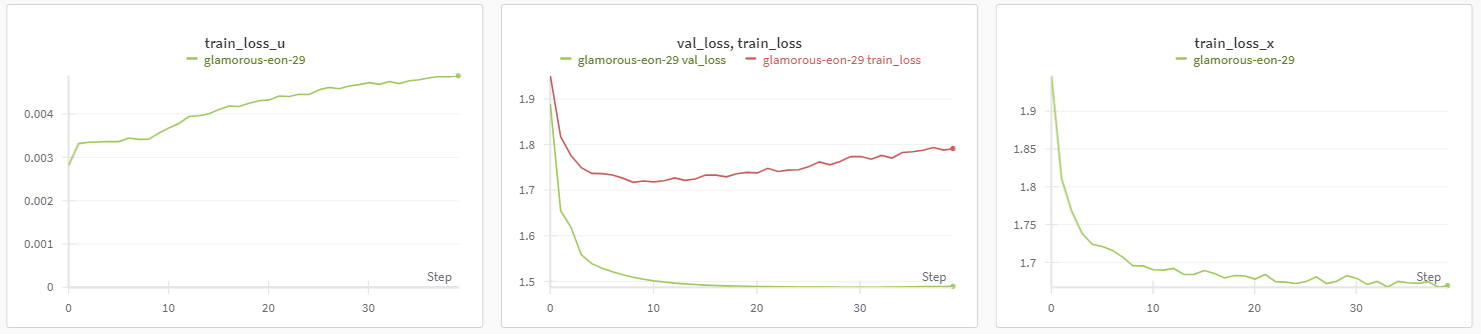

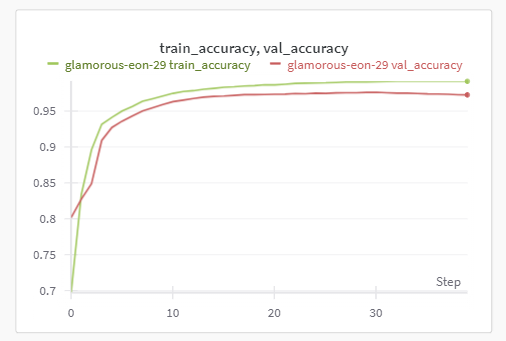

# Висновок


MixMatch — це напівконтрольований алгоритм навчання, розроблений для покращення продуктивності нейронних мереж у сценаріях, де позначених даних мало. Алгоритм використовує комбінацію методів, включаючи змішання, регулярізацію узгодженості та псевдо-мітки, щоб ефективно використовувати як мічені, так і немічені дані. MixMatch вирішує проблему навчання глибоких нейронних мереж у напівконтрольованому середовищі, заохочуючи модель виробляти узгоджені прогнози на розширених представленнях як мічених, так і немічених зразків.

Ключові компоненти MixMatch включають використання змішування, техніки доповнення даних, яка поєднує пари мічених і немічених зразків, створюючи синтетичний тренувальний сигнал. Цей процес спонукає модель вивчати більш надійні та узагальнювані представлення. Крім того, регулярізація узгодженості застосована для забезпечення узгодженості прогнозів у різних доповненнях того самого входу, підвищуючи здатність моделі до узагальнення.

Псевдомітки є ще одним важливим аспектом MixMatch, де модель генерує псевдомітки для немічених зразків на основі своїх поточних прогнозів. Потім ці псевдомітки використовуються для створення розширеного навчального набору, додатково використовуючи дані без міток для покращення навчання. Алгоритм вводить температурне масштабування для контролю достовірності призначень псевдоміток.

MixMatch демонструє свою ефективність за допомогою експериментів на різних контрольних наборах даних, демонструючи значні покращення в точності класифікації порівняно з традиційними підходами до навчання під наглядом, особливо коли дані з мітками обмежені. Успіх алгоритму полягає в його здатності ефективно використовувати як мічені, так і немічені зразки, демонструючи його корисність у сценаріях, коли отримати великі обсяги мічених даних є складним завданням.

Підсумовуючи, MixMatch виділяється як багатообіцяючий підхід у сфері напівконтрольованого навчання, забезпечуючи практичне рішення для покращення продуктивності глибоких нейронних мереж, коли мічених даних мало. Його поєднання стратегій змішування, регулярізації узгодженості та псевдоміток пропонує надійну структуру для навчання моделей на обмежених наборах даних із мітками, одночасно використовуючи потенціал великої кількості немаркованих даних для підвищення точності узагальнення та класифікації.

Аналіз результатів показав, що при навчанні на повному наборі даних модель показала точність в 98.46%, а при напівконтролюованому навчанні точність в 97.82%.
Порівняння методів простого навчання та спільного навчання підкреслює фундаментальну різницю у використанні даних для модельного навчання.
